In [1]:
import preprocessing.preprocessing as pp
import sampling
import random
import torch
from models import graphClassifier, nodeClassifier
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:

nodesFileNerve =  "~/Documents/Intestine/nerve-mask/nodes_nerve_bs2_fh.csv"
edgesFileNerve = "~/Documents/Intestine/nerve-mask/edges_nerve_bs2_fh.csv"

nodesFileLymph =  "~/Documents/Intestine/lymph-mask/nodes_lymph_bs2_fh.csv"
edgesFileLymph = "~/Documents/Intestine/lymph-mask/edges_lymph_bs2_fh.csv"



nodes_n = pd.read_csv(nodesFileNerve, sep = ";", index_col= "id")
edges_n = pd.read_csv(edgesFileNerve, sep = ";", index_col= "id")
nodes_l = pd.read_csv(nodesFileLymph, sep = ";", index_col= "id")
edges_l = pd.read_csv(edgesFileLymph, sep = ";", index_col= "id")


# scaling with the factors provided by luciano
nodes_l = pp.scalePosition(nodes_l, (1.65,1.65,6))
nodes_n = pp.scalePosition(nodes_n, (1.65,1.65,6))

# create the graphs for both networks
G_nerve = pp.createGraph(nodes_n, edges_n, index_addon ="n")
G_lymph = pp.createGraph(nodes_l, edges_l, index_addon ="l")

# get short description of graph
pp.graphSummary(G_nerve)
pp.graphSummary(G_lymph)

# get rid of self-loops, multi edges and isolated nodes
G_nerve_einf = pp.convertToEinfach(G_nerve)
G_lymph_einf = pp.convertToEinfach(G_lymph)

# enrich the attributes of the nodes with information from the incident edges
pp.enrichNodeAttributes(G_lymph_einf)
pp.enrichNodeAttributes(G_nerve_einf)


***************
Number of Nodes: 1861
Number of Edges: 2413
Number of Connected Components: 14
Number of Self Loops: 9
Number of Isolated Nodes: 0
Average Node Degree: 2.5932294465341212
***************
***************
Number of Nodes: 2152
Number of Edges: 2710
Number of Connected Components: 33
Number of Self Loops: 3
Number of Isolated Nodes: 0
Average Node Degree: 2.5185873605947955
***************


# Graph Classification using Subsets of Lymph and Nerve Network for Training and Testing

In [3]:

graph_node_num = 100

# create random samples 
randomSampleLymphNx, randomSampleLymph = sampling.randomGeomSubgraphs(G_lymph_einf, label = 1,starts = 100, node_sample_size = graph_node_num,  mode = "rnn")
randomSampleNerveNx, randomSampleNerve = sampling.randomGeomSubgraphs(G_nerve_einf, label = 0,starts = 100, node_sample_size = graph_node_num,  mode = "rnn")

# combine the graphs to a random set
allGraphs = randomSampleLymph + randomSampleNerve
random.shuffle(allGraphs)

# split into training and test set
breaker = int(len(allGraphs)*0.8)
train_dataset = allGraphs[:breaker]
test_dataset = allGraphs[breaker:]

Creating subgraphs using random node neighbor selection.: 100%|██████████| 100/100 [00:00<00:00, 461.80it/s]
Creating subgraphs using random node neighbor selection.: 100%|██████████| 100/100 [00:00<00:00, 477.62it/s]


In [4]:
# selection of the features to use
feat_slice = [1,3,7,8]

# create the model
model = graphClassifier.GCN_GC(hidden_channels=32, in_features = len(feat_slice), classes = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# create brach data loaders for training and test set
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



def train_GC():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x[:,feat_slice], data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test_GC(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x[:,feat_slice], data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.



for epoch in range(1, 101):
    train_GC()
    train_acc = test_GC(train_loader)
    test_acc = test_GC(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')



# good features: 1,3 - both features that have to do with length                performance is best if just these 2 features are used
# good features: 7,8 - both features that have to do with distance
# medium features: 6 - num Voxels
# medium features: 4 - curveness
# trash feature: 0,2 - both features that have to do with minRadiusAvg
# trash feature: 5 - avgRadiusStd



# 16 hidden layers seems favorable compared to 64 or 8

# slice = [1,3,7,8] leads to very good results
# slice = [1,3] results are equal to 1,3,7,8 ... maybe better

Epoch: 001, Train Acc: 0.5068, Test Acc: 0.4865
Epoch: 002, Train Acc: 0.5068, Test Acc: 0.4865
Epoch: 003, Train Acc: 0.5068, Test Acc: 0.4865
Epoch: 004, Train Acc: 0.5068, Test Acc: 0.4865
Epoch: 005, Train Acc: 0.6014, Test Acc: 0.4595
Epoch: 006, Train Acc: 0.6014, Test Acc: 0.4595
Epoch: 007, Train Acc: 0.5135, Test Acc: 0.5135
Epoch: 008, Train Acc: 0.4932, Test Acc: 0.5135
Epoch: 009, Train Acc: 0.7095, Test Acc: 0.7027
Epoch: 010, Train Acc: 0.5068, Test Acc: 0.4865
Epoch: 011, Train Acc: 0.5068, Test Acc: 0.4865
Epoch: 012, Train Acc: 0.8243, Test Acc: 0.8108
Epoch: 013, Train Acc: 0.7500, Test Acc: 0.7568
Epoch: 014, Train Acc: 0.6419, Test Acc: 0.6216
Epoch: 015, Train Acc: 0.7905, Test Acc: 0.8108
Epoch: 016, Train Acc: 0.7095, Test Acc: 0.6757
Epoch: 017, Train Acc: 0.5946, Test Acc: 0.4865
Epoch: 018, Train Acc: 0.8243, Test Acc: 0.7838
Epoch: 019, Train Acc: 0.7703, Test Acc: 0.7838
Epoch: 020, Train Acc: 0.6757, Test Acc: 0.6757
Epoch: 021, Train Acc: 0.8311, Test Acc:

# Node Classification using a contracted graph by spatial proximity to differentiate 3 node types (nerve, lymph, connected)

In [5]:
#rename the nodes to have unqiue identifiers for different types
# giving nodes from different files unique names
edges_n, nodes_n = pp.relable_edges_nodes(edges_n, nodes_n, "n")
edges_l, nodes_l = pp.relable_edges_nodes(edges_l, nodes_l, "l")


In [6]:
from scipy.sparse.csgraph import connected_components

# create an adjacency matrix for nodes from two node sets that are closer than a given distance
adjMcsr = pp.distance_based_adjacency(nodes_n, nodes_l, th = 0.03)

# find the connected components in the adjacency matrix (nodes that will be merged)
num, labels = connected_components(csgraph=adjMcsr, directed = False)

#create a dict where each new node contains all the nodes that will be merged into it
con_comp = pp.connected_components_dict(labels)

#take only the connected components that contain > 1 element, otherwise no merge is necessary 
rel_comp = pp.relevant_connected_components(con_comp, nodes_n.shape[0], ("n","l"))



reverse_dict= {}
for k, v in rel_comp.items():
    for val in v:
        reverse_dict[val] = k


In [7]:
merged_nodes = pd.concat([nodes_l.loc[:,["pos_x", "pos_y", "pos_z"]], nodes_n.loc[:,["pos_x", "pos_y", "pos_z"]]])
new_nodes = pd.DataFrame(columns=merged_nodes.columns )

# replace the contracted node with new nodes
# the position of the new node is an average of all the previous nodes
for k, valList in rel_comp.items():
    new_nodes.loc[k] = merged_nodes.loc[valList].mean()
    merged_nodes.drop(valList, inplace = True)


# concat the all nodes and the new nodes
merged_nodes = pd.concat([merged_nodes, new_nodes])

# createa a combined edge file
merged_edges = pd.concat([edges_l, edges_n], ignore_index = True)

print(merged_edges.shape[0])
drop_count = 0
# change the names of the edges to the new names
for idxE, edge in merged_edges.iterrows():
    if edge["node1id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node1id"] = reverse_dict[edge["node1id"]]
    if edge["node2id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node2id"] = reverse_dict[edge["node2id"]]
    if edge["hasNodeAtSampleBorder"]:
        merged_edges.drop([idxE], inplace = True)
        drop_count +=1

print(drop_count)
print(merged_edges.shape[0])

# create a new graph based on the old information
G_contract = pp.createGraph(merged_nodes, merged_edges)
G_contract_einf = pp.convertToEinfach(G_contract, self_loops = False, isolates = False)
pp.enrichNodeAttributes(G_contract_einf)

5123
0
5123


In [8]:
# create the ground truth for the node class
all_nodes = list(G_contract_einf.nodes)
nerve_class = np.array([elem[-1] == "n" for elem in all_nodes])*0
lymph_class = np.array([elem[-1] == "l" for elem in all_nodes])*1
combined_class = np.array([elem[-1] == "c" for elem in all_nodes])*2
class_assign = nerve_class+lymph_class+combined_class


# create the training and testing masks
train_mask = np.random.choice(np.arange(0, len(class_assign)), size= int(len(class_assign)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(class_assign)), train_mask)

# convert to torch tensor objects
train_mask= torch.tensor(train_mask)
test_mask= torch.tensor(test_mask)

np.random.seed(1234567)
unique, counts = np.unique(class_assign[train_mask], return_counts=True)
print("Train-Mask Class Distribution: ")
print(unique)
print(counts)

print("Test-Mask Class Distribution: ")
unique, counts = np.unique(class_assign[test_mask], return_counts=True)
print(unique)
print(counts)


# convert the graph to a networkx graph

from torch_geometric.utils.convert import from_networkx
networkXG = from_networkx(G_contract_einf)
networkXG.y = torch.tensor(class_assign)


Train-Mask Class Distribution: 
[0 1 2]
[1421 1650   64]
Test-Mask Class Distribution: 
[0 1 2]
[355 421   8]


In [9]:
num_feat = networkXG.x.shape[1]
num_class = len(np.unique(networkXG.y))
netGCN = nodeClassifier.GCN_VS
netSAGE = nodeClassifier.SAGE_VS

modelGCN = nodeClassifier.nodeClassifier(netGCN, hidden_channels=32, features = np.arange(num_feat),classes = num_class, num_layers= 6)
modelSAGE = nodeClassifier.nodeClassifier(netSAGE, hidden_channels=32, features = np.arange(num_feat),classes = num_class, num_layers= 6)

models = [modelGCN, modelSAGE]
#models = [modelGCN]


epochs = 200
loss_l = np.zeros((epochs, len(models)))
acc_l = np.zeros((epochs, len(models)))
for epoch in range(1, epochs +1):
      for i, model in enumerate(models):
            loss = model.train(networkXG, train_mask)
            loss_l[epoch-1, i] = loss.detach().numpy().copy()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            test_acc = model.test(networkXG, test_mask)
            acc_l[epoch-1, i] = test_acc

for model in models:
      test_acc = model.test(networkXG, test_mask)
      print(f'Test Accuracy: {test_acc:.4f}')

#100 iter:
#13: 58.75%       trash
#12: 58.75%       trash
#11: 62.03%
#10: 69.11 %
#9:  58.75 %      trash
#8:  78.69 %
#7:  78.40 %
#6:  81.08 %
#5:  58.75 %      trash
#4:  68.69 %
#3:  79.97 %
#2:  58.75 %      trash
#1:  79.97 %
#0:  58.75 %      trash

#all:        82.56 %
#no trash:   81.11 %
# >75:       81.96 %
#[1,6,8,10]: 80.77 %

#500 iter:
#all:        82.56 %


Epoch: 001, Loss: 109.3436
Epoch: 001, Loss: 1.1284
Epoch: 002, Loss: 50.5516
Epoch: 002, Loss: 1.0556
Epoch: 003, Loss: 50.4617
Epoch: 003, Loss: 0.9892
Epoch: 004, Loss: 27.9445
Epoch: 004, Loss: 0.9136
Epoch: 005, Loss: 25.5427
Epoch: 005, Loss: 0.8603
Epoch: 006, Loss: 20.9703
Epoch: 006, Loss: 0.8569
Epoch: 007, Loss: 12.2905
Epoch: 007, Loss: 0.8659
Epoch: 008, Loss: 11.4286
Epoch: 008, Loss: 0.8553
Epoch: 009, Loss: 11.9138
Epoch: 009, Loss: 0.8340
Epoch: 010, Loss: 12.5447
Epoch: 010, Loss: 0.8108
Epoch: 011, Loss: 10.7019
Epoch: 011, Loss: 0.8045
Epoch: 012, Loss: 7.7330
Epoch: 012, Loss: 0.7947
Epoch: 013, Loss: 6.0787
Epoch: 013, Loss: 0.7945
Epoch: 014, Loss: 5.3073
Epoch: 014, Loss: 0.7999
Epoch: 015, Loss: 4.9222
Epoch: 015, Loss: 0.7963
Epoch: 016, Loss: 3.6792
Epoch: 016, Loss: 0.7899
Epoch: 017, Loss: 2.7983
Epoch: 017, Loss: 0.7886
Epoch: 018, Loss: 3.1184
Epoch: 018, Loss: 0.7874
Epoch: 019, Loss: 2.6879
Epoch: 019, Loss: 0.7875
Epoch: 020, Loss: 2.4103
Epoch: 020, L

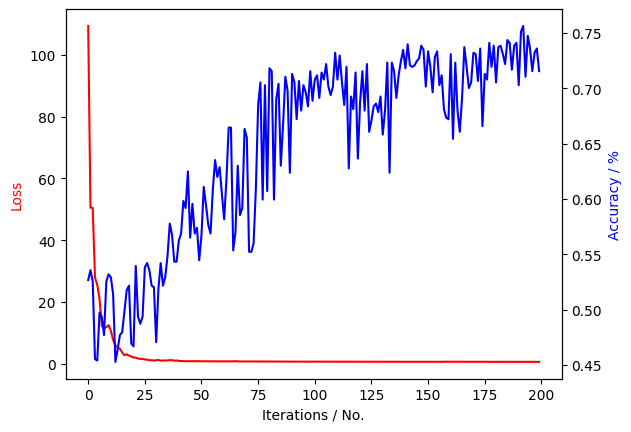

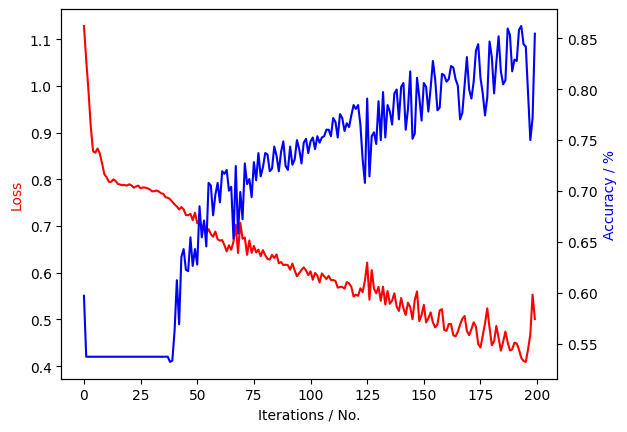

In [10]:
for i in range(len(models)):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(loss_l[:,i], color = "red")
    ax2.plot(acc_l[:,i], color = "blue")

    ax1.set_xlabel('Iterations / No.')
    ax1.set_ylabel('Loss', color='r')
    ax2.set_ylabel('Accuracy / %', color='b')



# Try node classification for the dual graph.

In [11]:
import networkx as nx
L = nx.line_graph(G_contract_einf)



dual_node_features ={}

for idxE, edge in merged_edges.iterrows():
    
    try:
        #L.nodes[edge["node1id"]].pos() - L.nodes[edge["node2id"]].pos()
        L[(edge["node1id"],edge["node2id"])]
        
        dual_node_features[(edge["node1id"],edge["node2id"])] = np.array(edge[2:], dtype = float)
    except KeyError:
        try:
            L[(edge["node2id"],edge["node1id"])]
            dual_node_features[(edge["node2id"],edge["node1id"])] = np.array(edge[2:], dtype = float)
        except KeyError:
            continue


nx.set_node_attributes(L, dual_node_features, name="x")


networkDualXG = from_networkx(L)

node_lab = {}
node_lab_explain = {}

class_label = -1
class_label_list = []
for k, node in L.nodes.items():
    hashval = hash(k[0][-1]) + hash(k[1][-1])
    try:
        class_label_list.append(node_lab[hashval])
    except KeyError:
        class_label = class_label +1
        node_lab[hashval] = class_label
        node_lab_explain[hashval] = (k[0][-1], k[1][-1])
        class_label_list.append(node_lab[hashval])


networkDualXG.y = torch.tensor(class_label_list)

for key in node_lab.keys():
    print("Class Label: " + str(node_lab[key]))
    print("Edge Type: " + str(node_lab_explain[key]))


print(networkDualXG.x.shape)
print(np.unique(class_label_list, return_counts= True))

Class Label: 0
Edge Type: ('l', 'l')
Class Label: 1
Edge Type: ('l', 'c')
Class Label: 2
Edge Type: ('n', 'n')
Class Label: 3
Edge Type: ('n', 'c')
Class Label: 4
Edge Type: ('c', 'c')
torch.Size([5040, 17])
(array([0, 1, 2, 3, 4]), array([2486,  180, 2185,  181,    8]))


/home/laurin/.local/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  data[key] = torch.tensor(value)


In [12]:
# create the training and testing masks
train_mask_dual = np.random.choice(np.arange(0, len(class_label_list)), size= int(len(class_label_list)*0.8), replace = False)
test_mask_dual = np.delete(np.arange(0, len(class_label_list)), train_mask_dual)

# convert to torch tensor objects
train_mask_dual= torch.tensor(train_mask_dual)
test_mask_dual= torch.tensor(test_mask_dual)


num_feat_dual = networkDualXG.x.shape[1]
num_class_dual = len(np.unique(networkDualXG.y))


In [13]:
optimizer = torch.optim.Adam
criterion = torch.nn.CrossEntropyLoss

modelGCN = nodeClassifier.nodeClassifier(netGCN, hidden_channels=32, features = np.arange(num_feat_dual),classes = num_class_dual, num_layers= 6)
modelSAGE = nodeClassifier.nodeClassifier(netSAGE, hidden_channels=32, features = np.arange(num_feat_dual),classes = num_class_dual, num_layers= 6)


models = [modelGCN, modelSAGE]


epochs = 200
loss_l = np.zeros((epochs, len(models)))
acc_l = np.zeros((epochs, len(models)))
for epoch in range(1, epochs +1):
      for i, model in enumerate(models):
            loss = model.train(networkDualXG, train_mask_dual)
            loss_l[epoch-1, i] = loss.detach().numpy().copy()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            test_acc = model.test(networkDualXG, test_mask_dual)
            acc_l[epoch-1, i] = test_acc

for model in models:
      test_acc = model.test(networkDualXG, test_mask_dual)
      print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 17278.6055
Epoch: 001, Loss: 1.5718
Epoch: 002, Loss: 8861.1201
Epoch: 002, Loss: 1.3082
Epoch: 003, Loss: 4989.6855
Epoch: 003, Loss: 1.1503
Epoch: 004, Loss: 2862.3865
Epoch: 004, Loss: 1.0914
Epoch: 005, Loss: 1776.6832
Epoch: 005, Loss: 1.0956
Epoch: 006, Loss: 1562.0873
Epoch: 006, Loss: 1.1224
Epoch: 007, Loss: 1378.5680
Epoch: 007, Loss: 1.1104
Epoch: 008, Loss: 1162.3821
Epoch: 008, Loss: 1.0541
Epoch: 009, Loss: 1013.9893
Epoch: 009, Loss: 1.0196
Epoch: 010, Loss: 666.7026
Epoch: 010, Loss: 1.0392
Epoch: 011, Loss: 500.7889
Epoch: 011, Loss: 1.0424
Epoch: 012, Loss: 511.1773
Epoch: 012, Loss: 1.0334
Epoch: 013, Loss: 444.3702
Epoch: 013, Loss: 1.0150
Epoch: 014, Loss: 377.1286
Epoch: 014, Loss: 0.9996
Epoch: 015, Loss: 310.4159
Epoch: 015, Loss: 0.9922
Epoch: 016, Loss: 259.9176
Epoch: 016, Loss: 0.9916
Epoch: 017, Loss: 200.5361
Epoch: 017, Loss: 1.0063
Epoch: 018, Loss: 130.0285
Epoch: 018, Loss: 0.9831
Epoch: 019, Loss: 114.2955
Epoch: 019, Loss: 0.9722
Ep

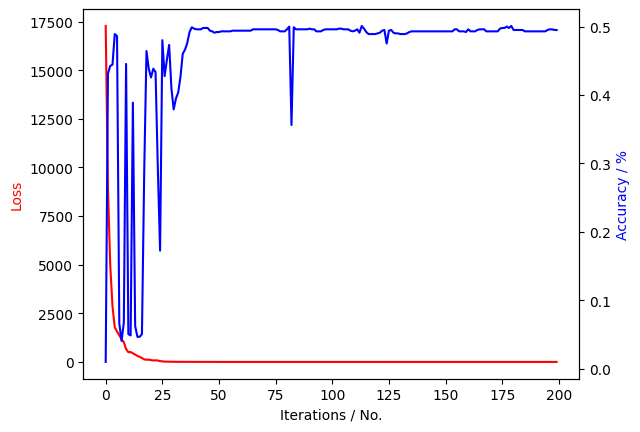

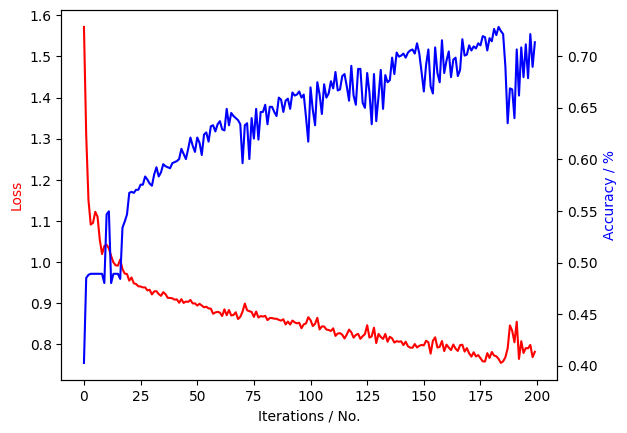

In [14]:
for i in range(len(models)):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(loss_l[:,i], color = "red")
    ax2.plot(acc_l[:,i], color = "blue")

    ax1.set_xlabel('Iterations / No.')
    ax1.set_ylabel('Loss', color='r')
    ax2.set_ylabel('Accuracy / %', color='b')

# Use wadb to perform parameter for hyperparameter search 

In [15]:
# give more room to the weight decay
sweep_variable_layyer_num = {
    "name": "gcn-sweep",
    "method": "bayes",
    "metric": {
        "name": "gcn/accuracy",
        "goal": "maximize",
    },
    "parameters": {
        
        "models": {
            "values": ["SAGE"]
        },
        "hidden_channels": {
            "values": [32, 64, 128]
        },

        "weight_decay": {
            "distribution": "normal",
            "mu": 1e-4,
            "sigma": 5e-5,
        },
        "lr": {
            "min": 1.5e-3,
            "max": 5e-2
        },
        "dropout": {
            "values": [0.5]
        },
        "num_layers": {
            "values": [8, 16]
        }
    }
}

# Register the Sweep with W&B
import wandb
#sweep_id = wandb.sweep(sweep_variable_layyer_num, project="node-classification_fh")

In [16]:
optimizerAdam = torch.optim.Adam
criterionCEL = torch.nn.CrossEntropyLoss

sweeper = nodeClassifier.nodeClassifierSweep(features = np.arange(num_feat_dual),classes = num_class_dual, optimizer = optimizerAdam, lossFunc = criterionCEL, graph = networkDualXG,  train_mask = train_mask, test_mask = test_mask, epochs = 200)

In [17]:
# Run the Sweeps agent
#wandb.agent(sweep_id, project="node-classification_fh", function=sweeper.agent_variable_size_model, count=20)

#sweeper.agent_variable_size_model()

In [18]:
bestMod = nodeClassifier.nodeClassifier(netSAGE, 64, features = np.arange(num_feat_dual), classes = num_class_dual,num_layers= 6,  lr = 0.0001548, weight_decay= 0.000192)


epochs = 500
loss_l = np.zeros((epochs, 1))
acc_l = np.zeros((epochs, 1))
for epoch in range(1, epochs +1):
      loss = bestMod.train(networkDualXG, train_mask_dual)
      loss_l[epoch-1] = loss.detach().numpy().copy()
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
      test_acc = bestMod.test(networkDualXG, test_mask_dual)
      acc_l[epoch-1] = test_acc


test_acc = bestMod.test(networkDualXG, test_mask_dual)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.8063
Epoch: 002, Loss: 1.7618
Epoch: 003, Loss: 1.6965
Epoch: 004, Loss: 1.6457
Epoch: 005, Loss: 1.6085
Epoch: 006, Loss: 1.5755
Epoch: 007, Loss: 1.5392
Epoch: 008, Loss: 1.5122
Epoch: 009, Loss: 1.4718
Epoch: 010, Loss: 1.4399
Epoch: 011, Loss: 1.4182
Epoch: 012, Loss: 1.3863
Epoch: 013, Loss: 1.3648
Epoch: 014, Loss: 1.3376
Epoch: 015, Loss: 1.3090
Epoch: 016, Loss: 1.2871
Epoch: 017, Loss: 1.2650
Epoch: 018, Loss: 1.2510
Epoch: 019, Loss: 1.2297
Epoch: 020, Loss: 1.2130
Epoch: 021, Loss: 1.1960
Epoch: 022, Loss: 1.1676
Epoch: 023, Loss: 1.1619
Epoch: 024, Loss: 1.1503
Epoch: 025, Loss: 1.1331
Epoch: 026, Loss: 1.1229
Epoch: 027, Loss: 1.1086
Epoch: 028, Loss: 1.0985
Epoch: 029, Loss: 1.0914
Epoch: 030, Loss: 1.0864
Epoch: 031, Loss: 1.0717
Epoch: 032, Loss: 1.0785
Epoch: 033, Loss: 1.0666
Epoch: 034, Loss: 1.0601
Epoch: 035, Loss: 1.0504
Epoch: 036, Loss: 1.0570
Epoch: 037, Loss: 1.0398
Epoch: 038, Loss: 1.0524
Epoch: 039, Loss: 1.0444
Epoch: 040, Loss: 1.0434


Text(0, 0.5, 'Accuracy / %')

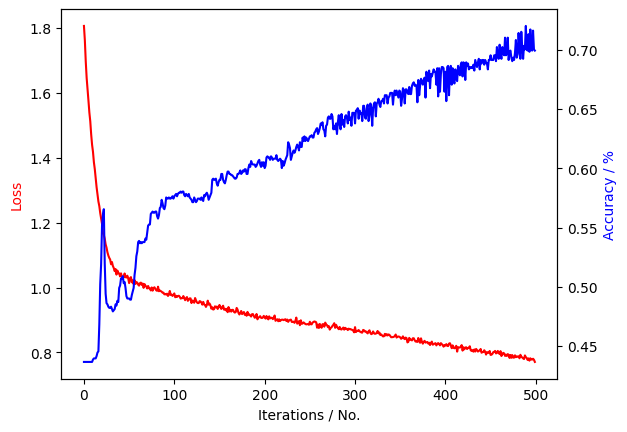

In [19]:

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(loss_l, color = "red")
ax2.plot(acc_l, color = "blue")

ax1.set_xlabel('Iterations / No.')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Accuracy / %', color='b')

In [20]:
import graph_matching.graph_matching as gm

nodesFileComb =  "~/Documents/Intestine/combined-mask/nodes_bs2_fh.csv"
edgesFileComb = "~/Documents/Intestine/combined-mask/edges_bs2_fh.csv"

nodes_c = pd.read_csv(nodesFileComb, sep = ";", index_col= "id")
edges_c = pd.read_csv(edgesFileComb, sep = ";", index_col= "id")

print(nodes_c.shape[0])
print(edges_c.shape[0])

# scaling with the factors provided by luciano
nodes_c = pp.scalePosition(nodes_c, (1.65,1.65,6))


G_contract_comb = pp.createGraph(nodes_c, edges_c)
G_contract_einf_comb = pp.convertToEinfach(G_contract_comb, self_loops = False, isolates = False)
G_contract_einf_comb_relab = gm.nearestNeighborLabeling(G_contract_einf, G_contract_einf_comb)


L = nx.line_graph(G_contract_einf_comb_relab)

feature_dict = {}


for edge in G_contract_einf_comb_relab.edges:
    feature_dict[edge] = G_contract_einf_comb_relab.edges[edge]["x"]

nx.set_node_attributes(L, feature_dict, name="x")


networkDualXGComb = from_networkx(L)

#node_lab = {} - use the previously defined ones, otherwise not same class labels
#node_lab_explain = {}

class_label = -1
class_label_list = []
for k, node in L.nodes.items():
    hashval = hash(k[0][-1]) + hash(k[1][-1])
    try:
        class_label_list.append(node_lab[hashval])
    except KeyError:
        class_label = class_label +1
        node_lab[hashval] = class_label
        node_lab_explain[hashval] = (k[0][-1], k[1][-1])
        class_label_list.append(node_lab[hashval])


networkDualXGComb.y = torch.tensor(class_label_list)

for key in node_lab.keys():
    print("Class Label: " + str(node_lab[key]))
    print("Edge Type: " + str(node_lab_explain[key]))

networkDualXGComb.y = torch.tensor(class_label_list)
print(networkDualXGComb.x.shape)

print(np.unique(class_label_list, return_counts=True))



3715
5135
Class Label: 0
Edge Type: ('l', 'l')
Class Label: 1
Edge Type: ('l', 'c')
Class Label: 2
Edge Type: ('n', 'n')
Class Label: 3
Edge Type: ('n', 'c')
Class Label: 4
Edge Type: ('c', 'c')
Class Label: 0
Edge Type: ('n', 'l')
torch.Size([5100, 17])
(array([0, 1, 2, 3, 4]), array([3293,  110, 1548,  104,   45]))


0.47784313725490196


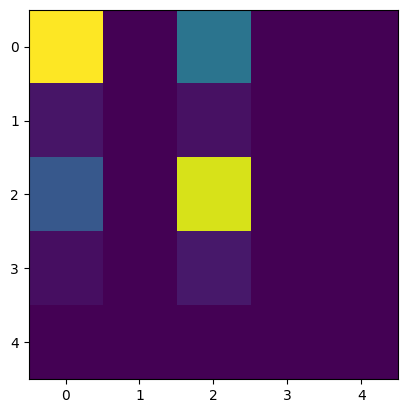

In [30]:
full_mask_dual_comb = torch.tensor(np.arange(0, networkDualXGComb.y.shape[0]))
pred_whole_comb = bestMod.predictions(networkDualXGComb, full_mask_dual_comb)
pred_whole_comb_acc = bestMod.test(networkDualXGComb, full_mask_dual_comb)

print(pred_whole_comb_acc)

cf_mat_comb = confusion_matrix(class_label_list, pred_whole_comb)
plt.imshow(cf_mat)

0.692063492063492


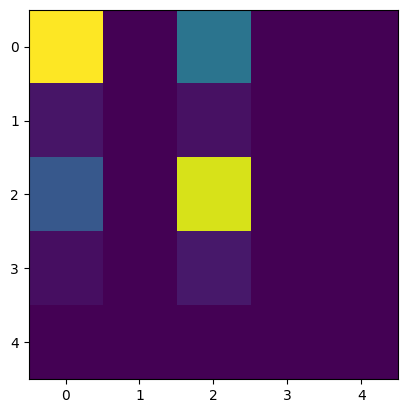

In [29]:
full_mask_dual = torch.tensor(np.arange(0, networkDualXG.y.shape[0]))
pred_whole = bestMod.predictions(networkDualXG, full_mask_dual)
pred_whole_acc = bestMod.test(networkDualXG, full_mask_dual)

print(pred_whole_acc)

cf_mat = confusion_matrix(networkDualXG.y, pred_whole)

plt.imshow(cf_mat)
